In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from sklearn.svm import SVC  
from sklearn import svm
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import lightgbm
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

In [5]:
race_table = pd.read_csv('nyra_race_table.csv')
start_table_cols = ['track_id', 'race_date', 'race_number', 'program_number', 'weight_carried', 'jockey', 'odds', 'position_at_finish']
start_table = pd.read_csv('nyra_start_table.csv', header=None, names = start_table_cols)
h_id = pd.read_csv('horse_ids.csv', index_col = 0)
h_name = pd.read_csv('horse_names.csv', index_col = 0)


df = start_table.merge(race_table, on=['track_id','race_date', 'race_number'], how='inner')

horse = h_id.merge(h_name, on = 'horse_id', how = 'inner')
horse['program_number'] = horse['program_number'].apply(lambda x: x.ljust(3, ' '))
df = df.merge(horse, left_on=['track_id', 'race_date', 'race_number', 'program_number'],
    right_on=['track_id', 'race_date', 'race', 'program_number'],how='left')


del h_id, h_name, start_table

In [6]:
df.isna().sum()

track_id              0
race_date             0
race_number           0
program_number        0
weight_carried        0
jockey                0
odds                  0
position_at_finish    0
distance_id           0
course_type           0
track_condition       0
run_up_distance       0
race_type             0
purse                 0
post_time             0
race                  0
horse_id              0
finishing_place       0
horse_name            0
dtype: int64

In [7]:
df.sort_values(by=['track_id', 'race_date', 'race_number', 'program_number'], ascending=[True]*4, inplace=True)

In [8]:
#eda 

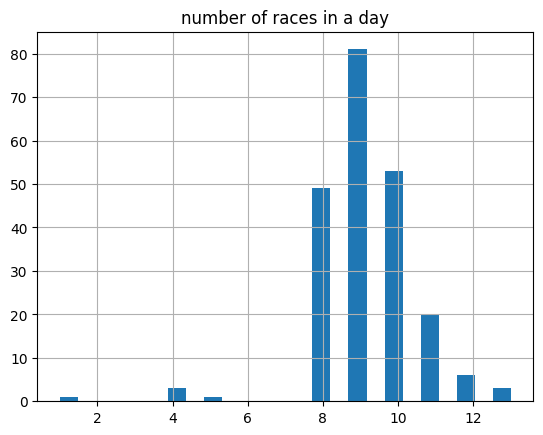

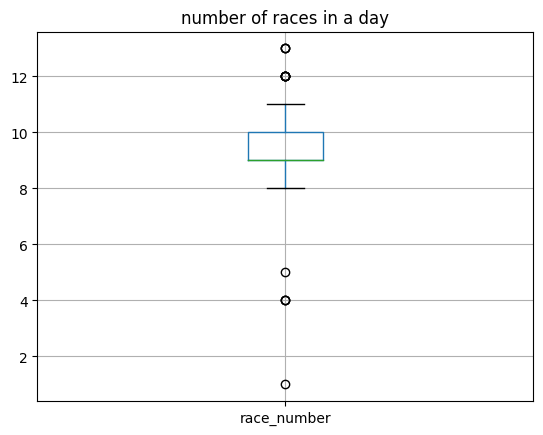

In [9]:
#number of races per day

n_race = race_table[['race_date', 'race_number']].groupby('race_date').count()

n_race.hist(bins = 25)
plt.title('number of races in a day')
plt.show()
n_race.boxplot()
plt.title('number of races in a day')
plt.show()

del n_race

<AxesSubplot: >

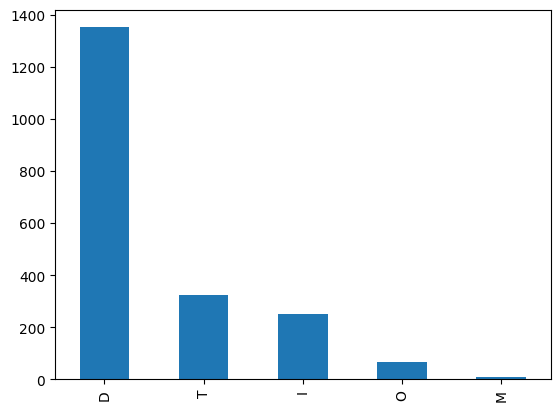

In [10]:
race_table['course_type'].value_counts().plot.bar()

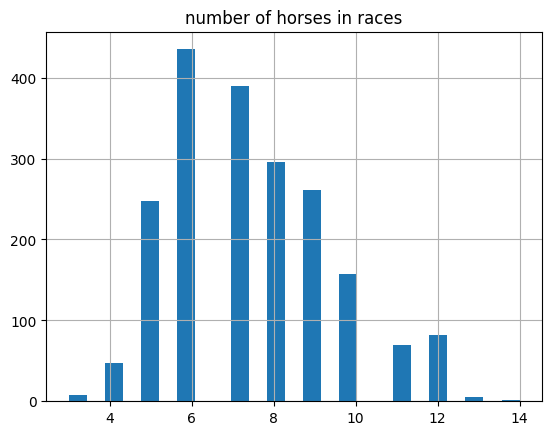

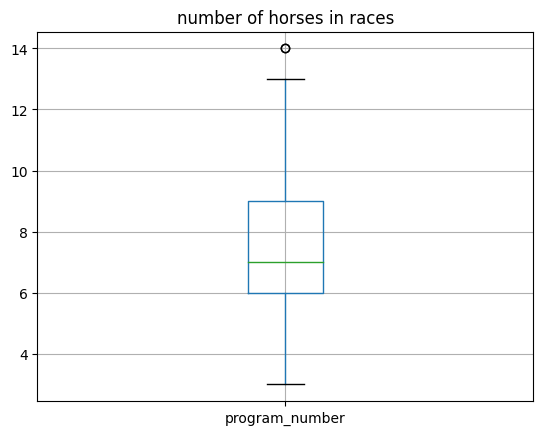

In [11]:
#number of horses in races

#n_horse = df[['race_date', 'race_number', 'program_number']].groupby(['race_date', 'race_number',]).count()

n_horse = df[['race_date', 'race_number', 'program_number']].groupby(['race_date', 'race_number',]).count()

n_horse.reset_index()[['program_number']].hist(bins = 25)
plt.title('number of horses in races')
plt.show()
n_horse.reset_index()[['program_number']].boxplot()
plt.title('number of horses in races')
plt.show()

#del n_horse

In [12]:
#remove races where n_horses not between 5 and 12

#define an index
df['id'] = range(1, df.shape[0] +1)

#create filter on index
nhorse_filter = n_horse[(n_horse['program_number']<4) | (n_horse['program_number']>12)].reset_index().iloc[:, :2]
nhorse_filter = df.merge(nhorse_filter, on=['race_date', 'race_number'], how='inner')

In [13]:
#drop rows
len(nhorse_filter)

117

In [14]:
df.drop(index = df[df['id'].isin(nhorse_filter['id'].values)].index, inplace=True)

Text(0.5, 0.98, 'Distance of Races (in Furlongs)')

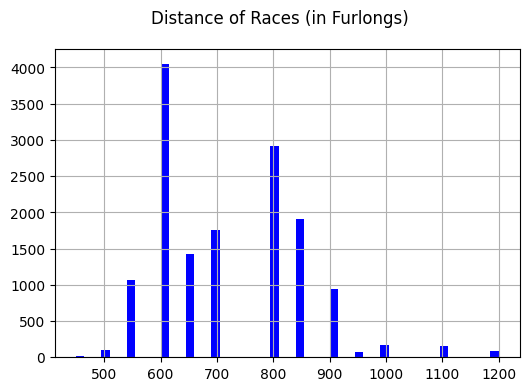

In [66]:
#distance of races

df['distance_id'].hist(bins = 50)
axes = df['distance_id'].hist(bins = 50, color = 'blue')
plt.suptitle("Distance of Races (in Furlongs)")


In [16]:
#drop 80 races that are outliers
df.drop(index = df[df['distance_id']>1200].index, inplace=True)

FT     6849
FM     3712
GD     2026
SY     1382
MY      504
YL      218
SF       19
Name: track_condition, dtype: int64

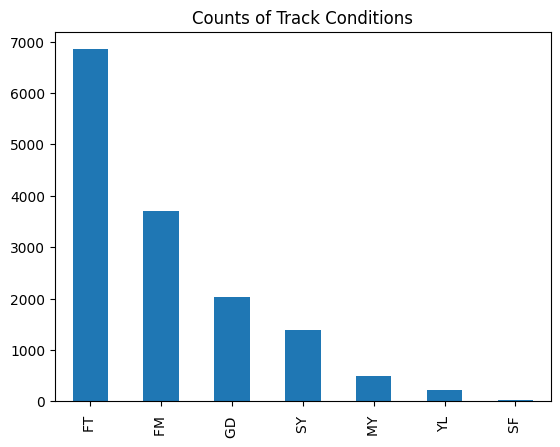

In [17]:
df['track_condition'].value_counts().plot.bar()
plt.title('Counts of Track Conditions')

df['track_condition'].value_counts()

In [18]:
#drop soft track conditions , 19 records

df.drop(index = df[df['track_condition'].str.split(',').isin([['SF '],])].index, inplace=True)

In [19]:
# M - Hurdle, D - Dirt, O - Outer turf, I - Inner turf, T - turf.

df['course_type'].value_counts()

D    9386
T    2763
I    1949
O     593
Name: course_type, dtype: int64

CLM    3294
MSW    3191
MCL    2667
STK    1748
AOC    1520
ALW    1463
STR     528
SOC     113
SST      75
WCL      69
WMC      12
SHP      11
Name: race_type, dtype: int64

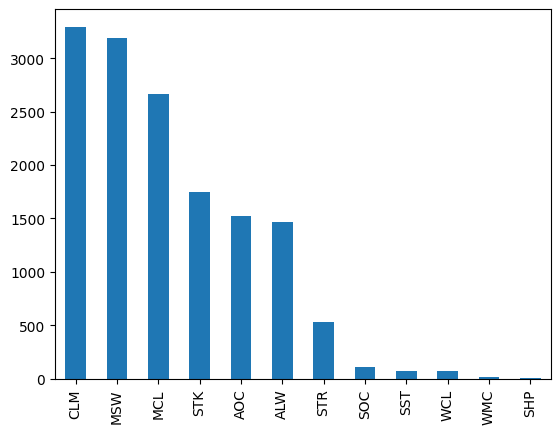

In [20]:
df['race_type'].value_counts().plot.bar()

df['race_type'].value_counts()

In [21]:
#drop WMC and SHP

#SHP dropped because this is a special category for handicapped horses
#WMC dropped because these are previously non-winners with ineligible horses
df.drop(index = df[df['race_type'].str.split(',').isin([['SHP'],['WMC']])].index, inplace=True)

In [22]:
#creating a binary label for win or lose

df['label'] = (df['position_at_finish']==1).astype(int)
df['label'].value_counts()

0    12697
1     1971
Name: label, dtype: int64

In [23]:
for column in ['track_id', 'course_type', 'track_condition', 'race_type']:
    dummy = pd.get_dummies(df[column])
    new_feature =  [f'{column}={name}' for name in dummy.columns]
    dummy.columns = new_feature
    df[new_feature] = dummy.values

Number of Jockeys = 159


Text(0.5, 1.0, 'Number of Races per Jockey')

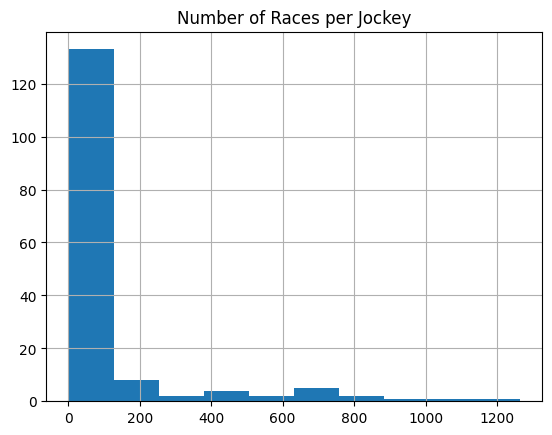

In [24]:
print('Number of Jockeys =', df['jockey'].nunique())

df['jockey'].value_counts().hist()
plt.title('Number of Races per Jockey')

In [67]:
max(df['jockey'].value_counts())

1263

In [25]:
(df['jockey'].value_counts() > 20).sum()

44

In [26]:
(df['jockey'].value_counts() < 20).sum()

115

In [27]:
(df['jockey'].value_counts() < 2).sum()

39

In [28]:
(df['jockey'].value_counts() < 4).sum()

73

39 out of 159 jockeys only have 1 race, and 61 jockeys have either 1 or 2 races, and 73 have less than 4 races!

Half the jockeys have little to no racing history. 

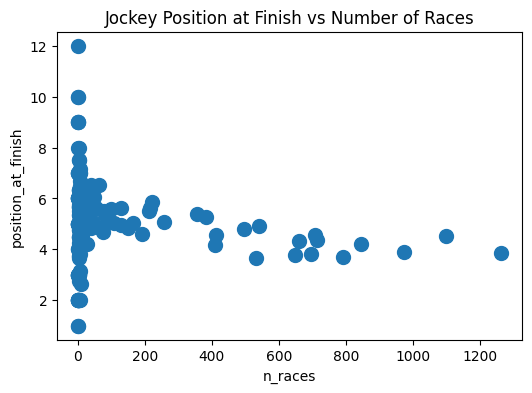

In [68]:
n_races = pd.DataFrame(df['jockey'].value_counts()).reset_index().rename(columns = {'jockey':'n_races', 'index':'jockey'})
positions = df[['jockey', 'position_at_finish']].groupby('jockey').mean().reset_index()
race_position = n_races.merge(positions, on = 'jockey', how = 'inner')

race_position.plot.scatter(x = 'n_races', y = 'position_at_finish', s = 100)
plt.title('Jockey Position at Finish vs Number of Races')

del race_position, n_races, positions

In [30]:
# giving unique numeric ID to jockeys

jockeys = df['jockey'].unique().tolist()
jockey_ids = pd.DataFrame(index=jockeys, data={'jockey_id': range(1, len(jockeys)+1)}).to_dict()['jockey_id']
df['jockey_id'] = df['jockey'].map(jockey_ids)

In [31]:
df.columns

Index(['track_id', 'race_date', 'race_number', 'program_number',
       'weight_carried', 'jockey', 'odds', 'position_at_finish', 'distance_id',
       'course_type', 'track_condition', 'run_up_distance', 'race_type',
       'purse', 'post_time', 'race', 'horse_id', 'finishing_place',
       'horse_name', 'id', 'label', 'track_id=AQU', 'track_id=BEL',
       'track_id=SAR', 'course_type=D', 'course_type=I', 'course_type=O',
       'course_type=T', 'track_condition=FM ', 'track_condition=FT ',
       'track_condition=GD ', 'track_condition=MY ', 'track_condition=SY ',
       'track_condition=YL ', 'race_type=ALW', 'race_type=AOC',
       'race_type=CLM', 'race_type=MCL', 'race_type=MSW', 'race_type=SOC',
       'race_type=SST', 'race_type=STK', 'race_type=STR', 'race_type=WCL',
       'jockey_id'],
      dtype='object')

In [32]:
#convert date to date_time
df['race_date'] = pd.to_datetime(df['race_date'])

In [33]:

#cumulative stats for horses are calculated and shifted by down by 1. 
#This is done so if a horse takes the first place in a certain race, the cumulative stats increase only for the next races. 

counts = (df[['horse_id', 'race_date', 'position_at_finish']].groupby(['horse_id', 'race_date']).count().rename(columns = {'position_at_finish' : 'horse_counts'})).reset_index()
counts = counts.sort_values(by=['horse_id', 'race_date'], ascending=[True]*2)
hold_1 = df[df['position_at_finish']<2][['horse_id', 'race_date', 'position_at_finish']].groupby(['horse_id', 'race_date']).count()
hold_1 = (hold_1.rename(columns = {'position_at_finish' : 'horse_wins'})).reset_index()
hold_1 = hold_1.sort_values(by=['horse_id', 'race_date'], ascending=[True]*2)
hold_3 = df[df['position_at_finish'].isin([1,2,3])][['horse_id', 'race_date', 'position_at_finish']].groupby(['horse_id', 'race_date']).count()
hold_3 = (hold_3.rename(columns = {'position_at_finish' : 'horse_top_3'})).reset_index()
hold_3 = hold_3.sort_values(by=['horse_id', 'race_date'], ascending=[True]*2)
counts = counts.merge(hold_1, on=['horse_id', 'race_date'], how='left')
counts = counts.merge(hold_3, on=['horse_id', 'race_date'], how='left')
counts = counts.fillna(0)
cumulative = counts.groupby('horse_id').cumsum()
counts['horse_races'] = cumulative['horse_counts']
counts['horse_wins'] = cumulative['horse_wins']
counts['horse_hold3'] = cumulative['horse_top_3']
counts = counts[['horse_id', 'race_date', 'horse_races', 'horse_wins', 'horse_hold3']]
lagged_counts = counts.groupby('horse_id').shift(1)
for column in lagged_counts.columns:
    counts[f'cumulative_{column}'] = lagged_counts[column]
counts = counts.fillna(0)
counts = counts[['horse_id', 'race_date', 'cumulative_horse_races', 'cumulative_horse_wins', 'cumulative_horse_hold3']]
df = df.merge(counts, on=['horse_id', 'race_date'], how='left')




#cumulative stats for jockeys are calculated and shifted by down by 1. 
#This is done so if a jockey takes the first place in a certain race, the cumulative stats increase only for the next races.

counts = (df[['jockey', 'race_date', 'position_at_finish']].groupby(['jockey', 'race_date']).count().rename(columns = {'position_at_finish' : 'jockey_counts'})).reset_index()
counts = counts.sort_values(by=['jockey', 'race_date'], ascending=[True]*2)
hold_1 = df[df['position_at_finish']<2][['jockey', 'race_date', 'position_at_finish']].groupby(['jockey', 'race_date']).count()
hold_1 = (hold_1.rename(columns = {'position_at_finish' : 'jockey_wins'})).reset_index()
hold_1 = hold_1.sort_values(by=['jockey', 'race_date'], ascending=[True]*2)
hold_3 = df[df['position_at_finish'].isin([1,2,3])][['jockey', 'race_date', 'position_at_finish']].groupby(['jockey', 'race_date']).count()
hold_3 = (hold_3.rename(columns = {'position_at_finish' : 'jockey_top_3'})).reset_index()
hold_3 = hold_3.sort_values(by=['jockey', 'race_date'], ascending=[True]*2)
counts = counts.merge(hold_1, on=['jockey', 'race_date'], how='left')
counts = counts.merge(hold_3, on=['jockey', 'race_date'], how='left')
counts = counts.fillna(0)
cumulative = counts.groupby('jockey').cumsum()
counts['jockey_races'] = cumulative['jockey_counts']
counts['jockey_wins'] = cumulative['jockey_wins']
counts['jockey_hold3'] = cumulative['jockey_top_3']
counts = counts[['jockey', 'race_date', 'jockey_races', 'jockey_wins', 'jockey_hold3']]
lagged_counts = counts.groupby('jockey').shift(1)
for column in lagged_counts.columns:
    counts[f'cumulative_{column}'] = lagged_counts[column]
counts = counts.fillna(0)
counts = counts[['jockey', 'race_date', 'cumulative_jockey_races', 'cumulative_jockey_wins', 'cumulative_jockey_hold3']]
df = df.merge(counts, on=['jockey', 'race_date'], how='left')


In [34]:
#view column names, verify new columns are added
df.columns

Index(['track_id', 'race_date', 'race_number', 'program_number',
       'weight_carried', 'jockey', 'odds', 'position_at_finish', 'distance_id',
       'course_type', 'track_condition', 'run_up_distance', 'race_type',
       'purse', 'post_time', 'race', 'horse_id', 'finishing_place',
       'horse_name', 'id', 'label', 'track_id=AQU', 'track_id=BEL',
       'track_id=SAR', 'course_type=D', 'course_type=I', 'course_type=O',
       'course_type=T', 'track_condition=FM ', 'track_condition=FT ',
       'track_condition=GD ', 'track_condition=MY ', 'track_condition=SY ',
       'track_condition=YL ', 'race_type=ALW', 'race_type=AOC',
       'race_type=CLM', 'race_type=MCL', 'race_type=MSW', 'race_type=SOC',
       'race_type=SST', 'race_type=STK', 'race_type=STR', 'race_type=WCL',
       'jockey_id', 'cumulative_horse_races', 'cumulative_horse_wins',
       'cumulative_horse_hold3', 'cumulative_jockey_races',
       'cumulative_jockey_wins', 'cumulative_jockey_hold3'],
      dtype='object'

In [35]:
#define features for training

features = ['weight_carried', 'odds', 'distance_id',
        'run_up_distance', 
       'purse', 'post_time', 'horse_id', 'track_id=AQU', 'track_id=BEL',
       'track_id=SAR', 'course_type=D', 'course_type=I', 'course_type=O',
       'course_type=T', 'track_condition=FM ', 'track_condition=FT ',
       'track_condition=GD ', 'track_condition=MY ', 'track_condition=SY ',
       'track_condition=YL ', 'race_type=ALW', 'race_type=AOC',
       'race_type=CLM', 'race_type=MCL', 'race_type=MSW', 'race_type=SOC',
       'race_type=SST', 'race_type=STK', 'race_type=STR', 'race_type=WCL',
       'jockey_id', 'cumulative_horse_races', 'cumulative_horse_wins',
       'cumulative_horse_hold3', 'cumulative_jockey_races',
       'cumulative_jockey_wins', 'cumulative_jockey_hold3']

In [36]:
#Minimum date
df['race_date'].min()

Timestamp('2019-01-01 00:00:00')

In [37]:
#Maximum date
df['race_date'].max()

Timestamp('2019-12-31 00:00:00')

Text(0.5, 1.0, 'Race Distribution by Dates')

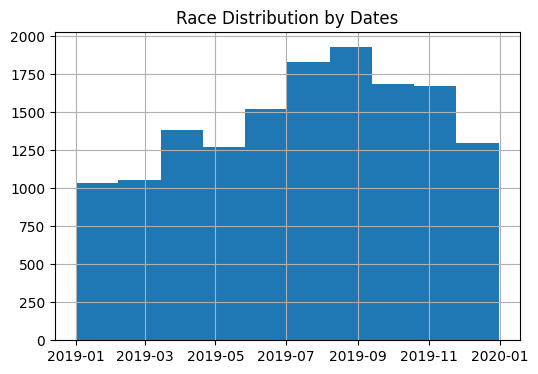

In [69]:
#Distributin of races over dates
plt.rcParams["figure.figsize"] = (6, 4)
df['race_date'].hist()
plt.title('Race Distribution by Dates')

In [73]:
#train and test length

train_start = '2019-01-01 00:00:00'
train_end = '2019-09-01 00:00:00'

test_start = '2019-09-01 00:00:01'
test_end = '2019-12-31 00:00:00'

In [74]:
#train test split
X_train = df[(df['race_date'] >= train_start) & (df['race_date'] <= train_end)][features]
y_train = df[(df['race_date'] >= train_start) & (df['race_date'] <= train_end)]['label']


X_test = df[(df['race_date'] >= test_start) & (df['race_date'] <= test_end)][features]
y_test = df[(df['race_date'] >= test_start) & (df['race_date'] <= test_end)]['label']

In [76]:
#Ratio of races won in training data
y_train.value_counts()/len(y_train)

0    0.862994
1    0.137006
Name: label, dtype: float64

In [77]:
#Ratio of races won in testing data
y_test.value_counts()/len(y_test)

0    0.870642
1    0.129358
Name: label, dtype: float64

# Logistic Regression

In [38]:
#Logistic Regression 
logit_model=sm.Logit(df['label'], df[features])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.345724
         Iterations 9
                                    Results: Logit
Model:                     Logit                   Pseudo R-squared:        0.124      
Dependent Variable:        label                   AIC:                     10210.1618 
Date:                      2022-11-28 13:27        BIC:                     10468.3382 
No. Observations:          14668                   Log-Likelihood:          -5071.1    
Df Model:                  33                      LL-Null:                 -5788.3    
Df Residuals:              14634                   LLR p-value:             1.2332e-280
Converged:                 1.0000                  Scale:                   1.0000     
No. Iterations:            9.0000                                                      
---------------------------------------------------------------------------------------
                         Coef.    Std.Err.      z     P

Accuracy of logistic regression classifier on test set: 0.87
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      4395
           1       0.00      0.00      0.00       653

    accuracy                           0.87      5048
   macro avg       0.44      0.50      0.47      5048
weighted avg       0.76      0.87      0.81      5048



C:\Users\DPS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DPS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DPS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


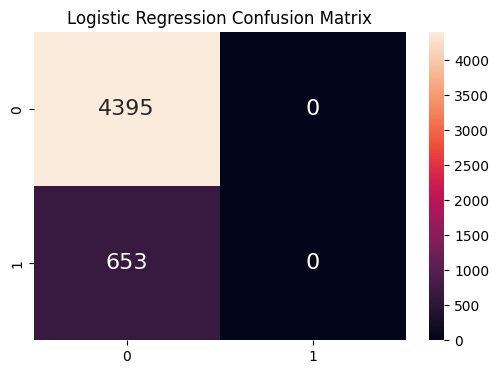

In [39]:



logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))


confusion_matrix_ = confusion_matrix(y_test, y_pred)
ax = plt.axes()
df_cm = pd.DataFrame(confusion_matrix_, range(2), range(2))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', ax = ax) # font size
ax.set_title('Logistic Regression Confusion Matrix')


print(classification_report(y_test, y_pred))



### Logistic Regression - Concluding Remarks

A box tidwell test was not performed to validate the assumptions of logistic regression because there aren't many continious 
variables within the dataset. But it is an emperical understanding that the variables do not have a reasonable linearity with the outcome of the logit. Therefore, a logistic regression model is not successfull. Rather we need a model that can work with the non-linearity and the categorical (one-hot-encoded) terms in the data.  

# Support Vector Classifier

Model accuracy score with default hyperparameters: 0.8706
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      4395
           1       0.00      0.00      0.00       653

    accuracy                           0.87      5048
   macro avg       0.44      0.50      0.47      5048
weighted avg       0.76      0.87      0.81      5048



C:\Users\DPS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DPS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DPS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


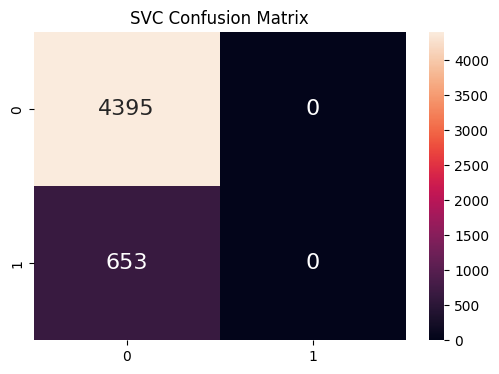

In [41]:
svc=SVC()

# fitting x samples and y classes  
svc.fit(X_train,y_train)

y_pred=svc.predict(X_test)

print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))


confusion_matrix_ = confusion_matrix(y_test, y_pred)
ax = plt.axes()
df_cm = pd.DataFrame(confusion_matrix_, range(2), range(2))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', ax = ax) # font size
ax.set_title('SVC Confusion Matrix')

print(classification_report(y_test, y_pred))

As expected, we obtain similar results. Class '0' dominates the outcomes, indicating towards and imbalance within the dataset. 

# LightGBM

### Feature Importance

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

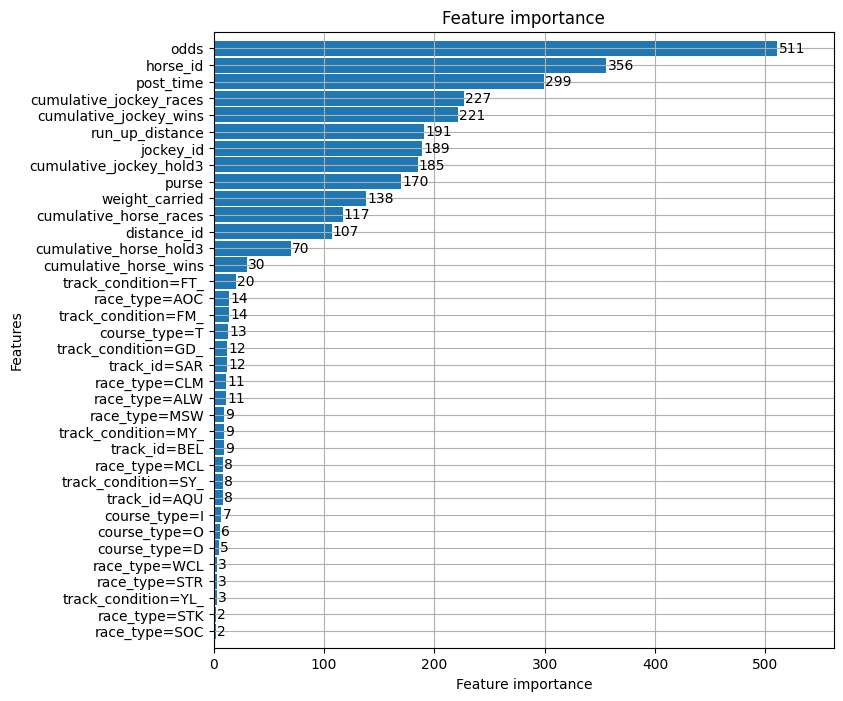

In [100]:

lgbm_model = LGBMClassifier()
lgbm_model.fit(df[features], df['label'])
plt.rcParams["figure.figsize"] = (8, 8)
lightgbm.plot_importance(lgbm_model, max_num_features = 40, height=.9)

### LightGBM Classification

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      4395
           1       0.46      0.07      0.12       653

    accuracy                           0.87      5048
   macro avg       0.67      0.53      0.53      5048
weighted avg       0.82      0.87      0.83      5048



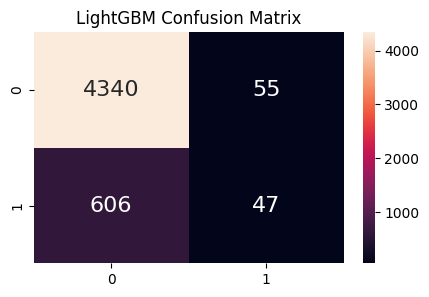

In [55]:
lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)

plt.rcParams["figure.figsize"] = (5, 3)

confusion_matrix_ = confusion_matrix(y_test, y_pred)
ax = plt.axes()
df_cm = pd.DataFrame(confusion_matrix_, range(2), range(2))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', ax = ax) # font size
ax.set_title('LightGBM Confusion Matrix')

#labels = ['True Neg','False Pos','False Neg','True Pos']
#labels = np.asarray(labels).reshape(2,2)
#sns.heatmap(confusion_matrix_, annot=labels, fmt='', cmap='Blues')

print(classification_report(y_test, y_pred))

Horse ID gives a high importance, check to see if raw Horse_ID values show any linearity or trend with the outcome variable

<AxesSubplot: xlabel='horse_id', ylabel='position_at_finish'>

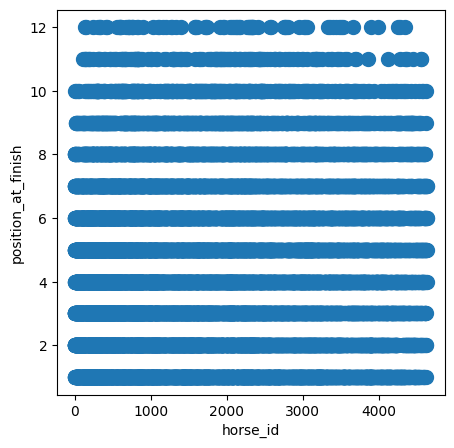

In [78]:
plt.rcParams["figure.figsize"] = (5, 5)
df.plot.scatter(x = 'horse_id', y = 'position_at_finish', s = 100)

<AxesSubplot: xlabel='horse_id', ylabel='label'>

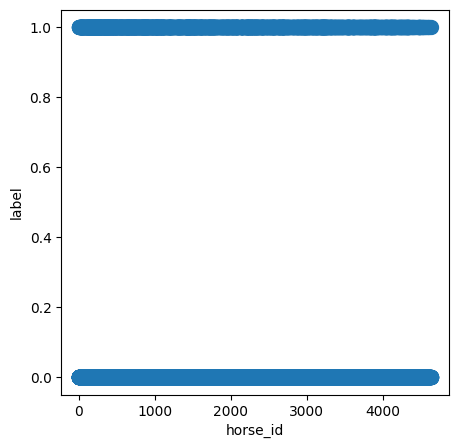

In [79]:
df.plot.scatter(x = 'horse_id', y = 'label', s = 100)

# LightGBM Stratified 

In [1]:
#lgmb stratified
#generating stratified folds which maintain the balance of the outcome class in each fold. 

In [111]:
clf = lgb.LGBMClassifier(class_weight='balanced',drop_rate=0.9, min_data_in_leaf=100, max_bin=255,
                                 n_estimators=500,min_sum_hessian_in_leaf=1,importance_type='gain',learning_rate=0.1,bagging_fraction = 0.85,
                                 colsample_bytree = 1.0,feature_fraction = 0.1,lambda_l1 = 5.0,lambda_l2 = 3.0,max_depth =  9,
                                 min_child_samples = 55,min_child_weight = 5.0,min_split_gain = 0.1,num_leaves = 45,subsample = 0.75)  

kf = StratifiedKFold(n_splits=5, shuffle=True)
# partially based on https://www.kaggle.com/c0conuts/xgb-k-folds-fastai-pca
predicts = []

X = X_train
y = y_train

for train_index, test_index in kf.split(X, y):
    print("###")
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
            early_stopping_rounds=20)
    predicts.append(clf.predict(X_test))

y_pred = np.mean(predicts, axis=0)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]

###
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=5.0 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=0.75 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0
[1]	valid_0's binary_logloss: 0.690594
[2]	valid_0's binary_logloss: 0.690729
[3]	valid_0's binary_logloss: 0.690897
[4]	valid_0's binary_logloss: 0.691037
[5]	valid_0's binary_logloss: 0.687126
[6]	valid_0's binary_logloss: 0.686765
[7]	valid_0's binary_logloss: 0.683712
[8]	valid_0's 

C:\Users\DPS\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[386]	valid_0's binary_logloss: 0.551709
[387]	valid_0's binary_logloss: 0.551709
[388]	valid_0's binary_logloss: 0.551697
[389]	valid_0's binary_logloss: 0.551697
[390]	valid_0's binary_logloss: 0.550995
[391]	valid_0's binary_logloss: 0.550935
[392]	valid_0's binary_logloss: 0.550952
[393]	valid_0's binary_logloss: 0.55066
[394]	valid_0's binary_logloss: 0.550438
[395]	valid_0's binary_logloss: 0.550438
[396]	valid_0's binary_logloss: 0.550438
[397]	valid_0's binary_logloss: 0.550387
[398]	valid_0's binary_logloss: 0.550387
[399]	valid_0's binary_logloss: 0.550549
[400]	valid_0's binary_logloss: 0.550549
[401]	valid_0's binary_logloss: 0.550549
[402]	valid_0's binary_logloss: 0.550622
[403]	valid_0's binary_logloss: 0.550622
[404]	valid_0's binary_logloss: 0.550565
[405]	valid_0's binary_logloss: 0.550521
[406]	valid_0's binary_logloss: 0.550536
[407]	valid_0's binary_logloss: 0.550536
[408]	valid_0's binary_logloss: 0.549737
[409]	valid_0's binary_logloss: 0.549773
[410]	valid_0's b

C:\Users\DPS\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[142]	valid_0's binary_logloss: 0.550766
[143]	valid_0's binary_logloss: 0.550959
[144]	valid_0's binary_logloss: 0.550959
[145]	valid_0's binary_logloss: 0.551044
[146]	valid_0's binary_logloss: 0.548493
[147]	valid_0's binary_logloss: 0.548697
[148]	valid_0's binary_logloss: 0.54887
[149]	valid_0's binary_logloss: 0.548998
[150]	valid_0's binary_logloss: 0.548447
[151]	valid_0's binary_logloss: 0.548413
[152]	valid_0's binary_logloss: 0.548099
[153]	valid_0's binary_logloss: 0.548179
[154]	valid_0's binary_logloss: 0.548173
[155]	valid_0's binary_logloss: 0.548251
[156]	valid_0's binary_logloss: 0.546382
[157]	valid_0's binary_logloss: 0.546382
[158]	valid_0's binary_logloss: 0.546465
[159]	valid_0's binary_logloss: 0.546465
[160]	valid_0's binary_logloss: 0.546438
[161]	valid_0's binary_logloss: 0.546
[162]	valid_0's binary_logloss: 0.546037
[163]	valid_0's binary_logloss: 0.546037
[164]	valid_0's binary_logloss: 0.546037
[165]	valid_0's binary_logloss: 0.545916
[166]	valid_0's bina

C:\Users\DPS\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[85]	valid_0's binary_logloss: 0.577614
[86]	valid_0's binary_logloss: 0.573302
[87]	valid_0's binary_logloss: 0.573134
[88]	valid_0's binary_logloss: 0.571999
[89]	valid_0's binary_logloss: 0.572037
[90]	valid_0's binary_logloss: 0.571809
[91]	valid_0's binary_logloss: 0.571596
[92]	valid_0's binary_logloss: 0.568173
[93]	valid_0's binary_logloss: 0.568193
[94]	valid_0's binary_logloss: 0.568204
[95]	valid_0's binary_logloss: 0.568238
[96]	valid_0's binary_logloss: 0.568369
[97]	valid_0's binary_logloss: 0.568189
[98]	valid_0's binary_logloss: 0.568189
[99]	valid_0's binary_logloss: 0.568294
[100]	valid_0's binary_logloss: 0.568375
[101]	valid_0's binary_logloss: 0.568379
[102]	valid_0's binary_logloss: 0.568435
[103]	valid_0's binary_logloss: 0.567884
[104]	valid_0's binary_logloss: 0.567834
[105]	valid_0's binary_logloss: 0.567834
[106]	valid_0's binary_logloss: 0.567834
[107]	valid_0's binary_logloss: 0.567833
[108]	valid_0's binary_logloss: 0.567748
[109]	valid_0's binary_logloss:

C:\Users\DPS\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DPS\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[12]	valid_0's binary_logloss: 0.642621
[13]	valid_0's binary_logloss: 0.642772
[14]	valid_0's binary_logloss: 0.64262
[15]	valid_0's binary_logloss: 0.642281
[16]	valid_0's binary_logloss: 0.642157
[17]	valid_0's binary_logloss: 0.62694
[18]	valid_0's binary_logloss: 0.625938
[19]	valid_0's binary_logloss: 0.625489
[20]	valid_0's binary_logloss: 0.613684
[21]	valid_0's binary_logloss: 0.613375
[22]	valid_0's binary_logloss: 0.612645
[23]	valid_0's binary_logloss: 0.611394
[24]	valid_0's binary_logloss: 0.601689
[25]	valid_0's binary_logloss: 0.601663
[26]	valid_0's binary_logloss: 0.60158
[27]	valid_0's binary_logloss: 0.601381
[28]	valid_0's binary_logloss: 0.60114
[29]	valid_0's binary_logloss: 0.601011
[30]	valid_0's binary_logloss: 0.599444
[31]	valid_0's binary_logloss: 0.599241
[32]	valid_0's binary_logloss: 0.599155
[33]	valid_0's binary_logloss: 0.599155
[34]	valid_0's binary_logloss: 0.599067
[35]	valid_0's binary_logloss: 0.599067
[36]	valid_0's binary_logloss: 0.598838
[37]

[33]	valid_0's binary_logloss: 0.619702
[34]	valid_0's binary_logloss: 0.619925
[35]	valid_0's binary_logloss: 0.619233
[36]	valid_0's binary_logloss: 0.619114
[37]	valid_0's binary_logloss: 0.619015
[38]	valid_0's binary_logloss: 0.618826
[39]	valid_0's binary_logloss: 0.618498
[40]	valid_0's binary_logloss: 0.618263
[41]	valid_0's binary_logloss: 0.618201
[42]	valid_0's binary_logloss: 0.61797
[43]	valid_0's binary_logloss: 0.618128
[44]	valid_0's binary_logloss: 0.608549
[45]	valid_0's binary_logloss: 0.608594
[46]	valid_0's binary_logloss: 0.601064
[47]	valid_0's binary_logloss: 0.600807
[48]	valid_0's binary_logloss: 0.600836
[49]	valid_0's binary_logloss: 0.600588
[50]	valid_0's binary_logloss: 0.600647
[51]	valid_0's binary_logloss: 0.600752
[52]	valid_0's binary_logloss: 0.600912
[53]	valid_0's binary_logloss: 0.601058
[54]	valid_0's binary_logloss: 0.60061
[55]	valid_0's binary_logloss: 0.6006
[56]	valid_0's binary_logloss: 0.600103
[57]	valid_0's binary_logloss: 0.599867
[58]

              precision    recall  f1-score   support

           0       0.92      0.80      0.86      4395
           1       0.28      0.54      0.37       653

    accuracy                           0.77      5048
   macro avg       0.60      0.67      0.61      5048
weighted avg       0.84      0.77      0.79      5048



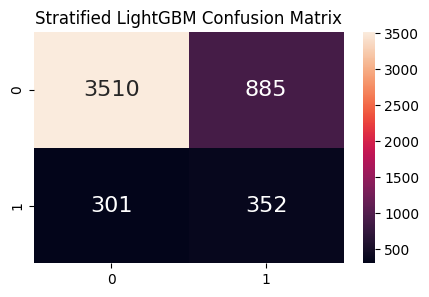

In [113]:
confusion_matrix_ = confusion_matrix(y_test, y_pred)
ax = plt.axes()
df_cm = pd.DataFrame(confusion_matrix_, range(2), range(2))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', ax = ax) # font size
ax.set_title('Stratified LightGBM Confusion Matrix')

print(classification_report(y_test, y_pred))

# SMOTE - Handling Class Imbalance

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

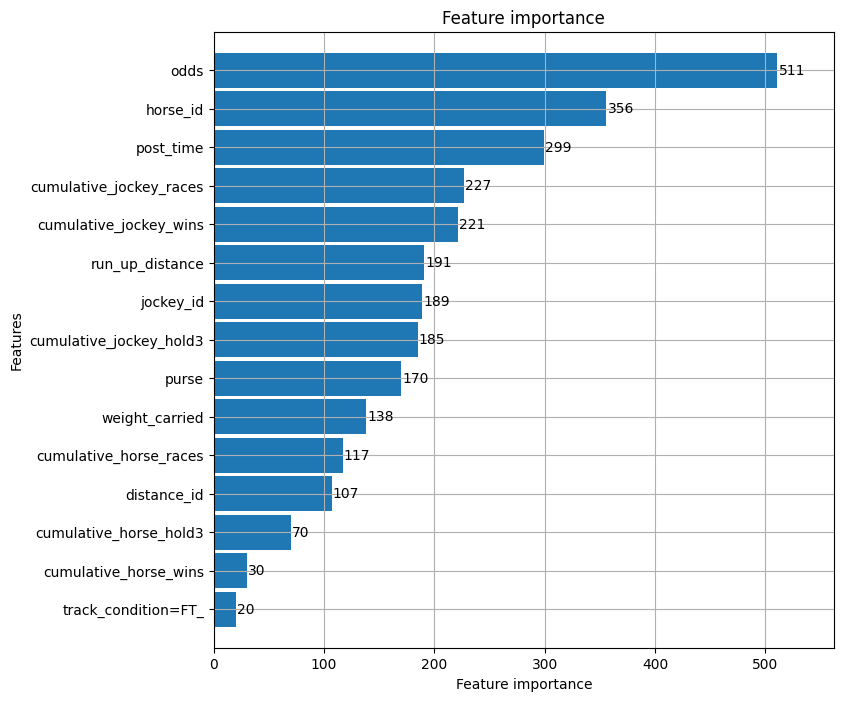

In [99]:
#15 most important features

lgbm_model = LGBMClassifier()
lgbm_model.fit(df[features], df['label'])
plt.rcParams["figure.figsize"] = (8, 8)
lightgbm.plot_importance(lgbm_model, max_num_features = 15, height=.9)

In [46]:
#15 imp features
feats_imp = ['weight_carried', 'odds', 'distance_id', 'run_up_distance', 'purse','horse_id', 'post_time',
             'cumulative_jockey_races', 'cumulative_jockey_wins', 'jockey_id', 'cumulative_jockey_hold3', 
            'cumulative_horse_races','cumulative_horse_wins', 'cumulative_horse_hold3', 'track_condition=FT ']


X = X_train[feats_imp]
y = y_train
X_test_res = X_test[feats_imp]

from imblearn.over_sampling import BorderlineSMOTE
sm = BorderlineSMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

print('Original Balance =', y.sum()/len(y))
print('SMOTE Oversampling Balance =', y_res.sum()/len(y_res))

Original Balance = 0.137006237006237
SMOTE Oversampling Balance = 0.5


### LightGBM with synthetic data generated by SMOTE 

In [50]:
clf = lgb.LGBMClassifier(class_weight='balanced',drop_rate=0.9, min_data_in_leaf=100, max_bin=255,
                                 n_estimators=500,min_sum_hessian_in_leaf=1,importance_type='gain',learning_rate=0.1,bagging_fraction = 0.85,
                                 colsample_bytree = 1.0,feature_fraction = 0.1,lambda_l1 = 5.0,lambda_l2 = 3.0,max_depth =  9,
                                 min_child_samples = 55,min_child_weight = 5.0,min_split_gain = 0.1,num_leaves = 45,subsample = 0.75)  



kf = StratifiedKFold(n_splits=5, shuffle=True)
# partially based on https://www.kaggle.com/c0conuts/xgb-k-folds-fastai-pca
predicts = []

X = X_res
y = y_res

for train_index, test_index in kf.split(X, y):
    print("###")
    X_train_, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train_, y_val = y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train_, y_train_, eval_set=[(X_val, y_val)], 
            early_stopping_rounds=20)
    predicts.append(clf.predict(X_test_res))

y_pred = np.mean(predicts, axis=0)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]

###
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=5.0 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=0.75 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0
[1]	valid_0's binary_logloss: 0.681382
[2]	valid_0's binary_logloss: 0.648275
[3]	valid_0's binary_logloss: 0.619776
[4]	valid_0's binary_logloss: 0.604992
[5]	valid_0's binary_logloss: 0.594379
[6]	valid_0's binary_logloss: 0.589045
[7]	valid_0's binary_logloss: 0.569625
[8]	valid_0's 

C:\Users\DPS\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[145]	valid_0's binary_logloss: 0.233312
[146]	valid_0's binary_logloss: 0.233228
[147]	valid_0's binary_logloss: 0.233211
[148]	valid_0's binary_logloss: 0.233182
[149]	valid_0's binary_logloss: 0.233168
[150]	valid_0's binary_logloss: 0.233081
[151]	valid_0's binary_logloss: 0.232434
[152]	valid_0's binary_logloss: 0.232309
[153]	valid_0's binary_logloss: 0.231508
[154]	valid_0's binary_logloss: 0.231284
[155]	valid_0's binary_logloss: 0.231272
[156]	valid_0's binary_logloss: 0.230833
[157]	valid_0's binary_logloss: 0.230835
[158]	valid_0's binary_logloss: 0.230865
[159]	valid_0's binary_logloss: 0.230778
[160]	valid_0's binary_logloss: 0.230786
[161]	valid_0's binary_logloss: 0.230164
[162]	valid_0's binary_logloss: 0.230124
[163]	valid_0's binary_logloss: 0.230124
[164]	valid_0's binary_logloss: 0.230072
[165]	valid_0's binary_logloss: 0.230072
[166]	valid_0's binary_logloss: 0.229909
[167]	valid_0's binary_logloss: 0.229942
[168]	valid_0's binary_logloss: 0.229875
[169]	valid_0's 

C:\Users\DPS\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=5.0 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=0.75 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0
[1]	valid_0's binary_logloss: 0.684927
[2]	valid_0's binary_logloss: 0.653332
[3]	valid_0's binary_logloss: 0.624383
[4]	valid_0's binary_logloss: 0.609219
[5]	valid_0's binary_logloss: 0.600901
[6]	valid_0's binary_logloss: 0.59613
[7]	valid_0's binary_logloss: 0.577033
[8]	valid_0's binar

C:\Users\DPS\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[24]	valid_0's binary_logloss: 0.407984
[25]	valid_0's binary_logloss: 0.401271
[26]	valid_0's binary_logloss: 0.392937
[27]	valid_0's binary_logloss: 0.389612
[28]	valid_0's binary_logloss: 0.376006
[29]	valid_0's binary_logloss: 0.375502
[30]	valid_0's binary_logloss: 0.371403
[31]	valid_0's binary_logloss: 0.367073
[32]	valid_0's binary_logloss: 0.366416
[33]	valid_0's binary_logloss: 0.363239
[34]	valid_0's binary_logloss: 0.362101
[35]	valid_0's binary_logloss: 0.359314
[36]	valid_0's binary_logloss: 0.355616
[37]	valid_0's binary_logloss: 0.34523
[38]	valid_0's binary_logloss: 0.340106
[39]	valid_0's binary_logloss: 0.336784
[40]	valid_0's binary_logloss: 0.332272
[41]	valid_0's binary_logloss: 0.328213
[42]	valid_0's binary_logloss: 0.327056
[43]	valid_0's binary_logloss: 0.323231
[44]	valid_0's binary_logloss: 0.322356
[45]	valid_0's binary_logloss: 0.319655
[46]	valid_0's binary_logloss: 0.312383
[47]	valid_0's binary_logloss: 0.310404
[48]	valid_0's binary_logloss: 0.30853
[4

C:\Users\DPS\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[62]	valid_0's binary_logloss: 0.280393
[63]	valid_0's binary_logloss: 0.279464
[64]	valid_0's binary_logloss: 0.278763
[65]	valid_0's binary_logloss: 0.277768
[66]	valid_0's binary_logloss: 0.277679
[67]	valid_0's binary_logloss: 0.276392
[68]	valid_0's binary_logloss: 0.2751
[69]	valid_0's binary_logloss: 0.274492
[70]	valid_0's binary_logloss: 0.271132
[71]	valid_0's binary_logloss: 0.270383
[72]	valid_0's binary_logloss: 0.267515
[73]	valid_0's binary_logloss: 0.264753
[74]	valid_0's binary_logloss: 0.264578
[75]	valid_0's binary_logloss: 0.264003
[76]	valid_0's binary_logloss: 0.263437
[77]	valid_0's binary_logloss: 0.263258
[78]	valid_0's binary_logloss: 0.260913
[79]	valid_0's binary_logloss: 0.260402
[80]	valid_0's binary_logloss: 0.260286
[81]	valid_0's binary_logloss: 0.25967
[82]	valid_0's binary_logloss: 0.259647
[83]	valid_0's binary_logloss: 0.259211
[84]	valid_0's binary_logloss: 0.258524
[85]	valid_0's binary_logloss: 0.258065
[86]	valid_0's binary_logloss: 0.257694
[87

[277]	valid_0's binary_logloss: 0.229582
[278]	valid_0's binary_logloss: 0.229582
[279]	valid_0's binary_logloss: 0.229582
[280]	valid_0's binary_logloss: 0.229584
[281]	valid_0's binary_logloss: 0.229601
[282]	valid_0's binary_logloss: 0.229581
[283]	valid_0's binary_logloss: 0.229581
[284]	valid_0's binary_logloss: 0.229581
[285]	valid_0's binary_logloss: 0.229581
[286]	valid_0's binary_logloss: 0.229581
[287]	valid_0's binary_logloss: 0.229545
[288]	valid_0's binary_logloss: 0.229566
[289]	valid_0's binary_logloss: 0.229571
[290]	valid_0's binary_logloss: 0.229563
[291]	valid_0's binary_logloss: 0.229539
[292]	valid_0's binary_logloss: 0.229527
[293]	valid_0's binary_logloss: 0.229505
[294]	valid_0's binary_logloss: 0.229504
[295]	valid_0's binary_logloss: 0.229499
[296]	valid_0's binary_logloss: 0.229489
[297]	valid_0's binary_logloss: 0.229489
[298]	valid_0's binary_logloss: 0.229489
[299]	valid_0's binary_logloss: 0.229489
[300]	valid_0's binary_logloss: 0.229489
[301]	valid_0's 

C:\Users\DPS\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[52]	valid_0's binary_logloss: 0.296854
[53]	valid_0's binary_logloss: 0.295964
[54]	valid_0's binary_logloss: 0.29405
[55]	valid_0's binary_logloss: 0.288625
[56]	valid_0's binary_logloss: 0.287337
[57]	valid_0's binary_logloss: 0.285998
[58]	valid_0's binary_logloss: 0.284824
[59]	valid_0's binary_logloss: 0.284119
[60]	valid_0's binary_logloss: 0.282214
[61]	valid_0's binary_logloss: 0.281071
[62]	valid_0's binary_logloss: 0.280192
[63]	valid_0's binary_logloss: 0.278867
[64]	valid_0's binary_logloss: 0.27812
[65]	valid_0's binary_logloss: 0.276764
[66]	valid_0's binary_logloss: 0.276691
[67]	valid_0's binary_logloss: 0.275237
[68]	valid_0's binary_logloss: 0.274173
[69]	valid_0's binary_logloss: 0.273527
[70]	valid_0's binary_logloss: 0.269683
[71]	valid_0's binary_logloss: 0.268897
[72]	valid_0's binary_logloss: 0.265536
[73]	valid_0's binary_logloss: 0.262521
[74]	valid_0's binary_logloss: 0.26241
[75]	valid_0's binary_logloss: 0.261821
[76]	valid_0's binary_logloss: 0.261112
[77

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      4395
           1       0.37      0.07      0.12       653

    accuracy                           0.86      5048
   macro avg       0.62      0.53      0.52      5048
weighted avg       0.81      0.86      0.82      5048



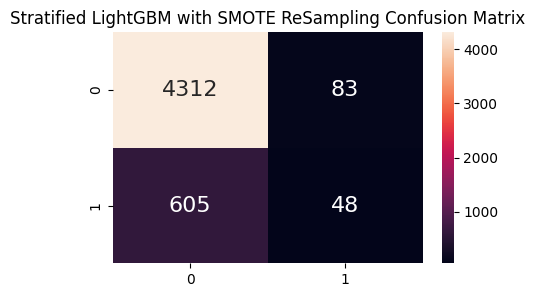

In [51]:
plt.rcParams["figure.figsize"] = (5, 3)
confusion_matrix_ = confusion_matrix(y_test, y_pred)
ax = plt.axes()
df_cm = pd.DataFrame(confusion_matrix_, range(2), range(2))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', ax = ax) # font size
ax.set_title('Stratified LightGBM with SMOTE ReSampling Confusion Matrix')

print(classification_report(y_test, y_pred))

Performance has decreased. It's doing more harm than good. 
-- There can only be so many winners in any given race. 

# Re-Engineering the Target Variable

In [43]:
#changing target variable to be '1' if position in [1,2,3]
#Otherwise target is '0' for any other position. 

In [44]:
target2 = [df['position_at_finish'] < 4]
target2 = [int(i) for i in target2[0]]
df['place_holder'] = target2

In [45]:
#train test split
X_train = df[(df['race_date'] >= train_start) & (df['race_date'] <= train_end)][features]
y_train = df[(df['race_date'] >= train_start) & (df['race_date'] <= train_end)]['place_holder']


X_test = df[(df['race_date'] >= test_start) & (df['race_date'] <= test_end)][features]
y_test = df[(df['race_date'] >= test_start) & (df['race_date'] <= test_end)]['place_holder']

In [46]:
clf = lgb.LGBMClassifier(class_weight='balanced',drop_rate=0.9, min_data_in_leaf=100, max_bin=255,
                                 n_estimators=500,min_sum_hessian_in_leaf=1,importance_type='gain',learning_rate=0.1,bagging_fraction = 0.85,
                                 colsample_bytree = 1.0,feature_fraction = 0.1,lambda_l1 = 5.0,lambda_l2 = 3.0,max_depth =  9,
                                 min_child_samples = 55,min_child_weight = 5.0,min_split_gain = 0.1,num_leaves = 45,subsample = 0.75)  

kf = StratifiedKFold(n_splits=5, shuffle=True)
# partially based on https://www.kaggle.com/c0conuts/xgb-k-folds-fastai-pca
predicts = []

X = X_train
y = y_train

for train_index, test_index in kf.split(X, y):
    print("###")
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
            early_stopping_rounds=20)
    predicts.append(clf.predict(X_test))

y_pred = np.mean(predicts, axis=0)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]

###
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=5.0 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=0.75 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0
[1]	valid_0's binary_logloss: 0.691607
[2]	valid_0's binary_logloss: 0.691253
[3]	valid_0's binary_logloss: 0.690883
[4]	valid_0's binary_logloss: 0.690712
[5]	valid_0's binary_logloss: 0.687464
[6]	valid_0's binary_logloss: 0.687199
[7]	valid_0's binary_logloss: 0.684675
[8]	valid_0's 

[1]	valid_0's binary_logloss: 0.691717
[2]	valid_0's binary_logloss: 0.691205
[3]	valid_0's binary_logloss: 0.690708
[4]	valid_0's binary_logloss: 0.690645
[5]	valid_0's binary_logloss: 0.687603
[6]	valid_0's binary_logloss: 0.687377
[7]	valid_0's binary_logloss: 0.685007
[8]	valid_0's binary_logloss: 0.684392
[9]	valid_0's binary_logloss: 0.683462
[10]	valid_0's binary_logloss: 0.683249
[11]	valid_0's binary_logloss: 0.683049
[12]	valid_0's binary_logloss: 0.680655
[13]	valid_0's binary_logloss: 0.67998
[14]	valid_0's binary_logloss: 0.679878
[15]	valid_0's binary_logloss: 0.680014
[16]	valid_0's binary_logloss: 0.679773
[17]	valid_0's binary_logloss: 0.679618
[18]	valid_0's binary_logloss: 0.679111
[19]	valid_0's binary_logloss: 0.678802
[20]	valid_0's binary_logloss: 0.664255
[21]	valid_0's binary_logloss: 0.664007
[22]	valid_0's binary_logloss: 0.662897
[23]	valid_0's binary_logloss: 0.66269
[24]	valid_0's binary_logloss: 0.662599
[25]	valid_0's binary_logloss: 0.662506
[26]	valid_

[1]	valid_0's binary_logloss: 0.692035
[2]	valid_0's binary_logloss: 0.691589
[3]	valid_0's binary_logloss: 0.691156
[4]	valid_0's binary_logloss: 0.691088
[5]	valid_0's binary_logloss: 0.688019
[6]	valid_0's binary_logloss: 0.687748
[7]	valid_0's binary_logloss: 0.684662
[8]	valid_0's binary_logloss: 0.684435
[9]	valid_0's binary_logloss: 0.683531
[10]	valid_0's binary_logloss: 0.683388
[11]	valid_0's binary_logloss: 0.683174
[12]	valid_0's binary_logloss: 0.680441
[13]	valid_0's binary_logloss: 0.679841
[14]	valid_0's binary_logloss: 0.679731
[15]	valid_0's binary_logloss: 0.679712
[16]	valid_0's binary_logloss: 0.679442
[17]	valid_0's binary_logloss: 0.679303
[18]	valid_0's binary_logloss: 0.678922
[19]	valid_0's binary_logloss: 0.678335
[20]	valid_0's binary_logloss: 0.663343
[21]	valid_0's binary_logloss: 0.663197
[22]	valid_0's binary_logloss: 0.662007
[23]	valid_0's binary_logloss: 0.661942
[24]	valid_0's binary_logloss: 0.66179
[25]	valid_0's binary_logloss: 0.661769
[26]	valid

###
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=5.0 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=0.75 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0
[1]	valid_0's binary_logloss: 0.691801
[2]	valid_0's binary_logloss: 0.69141
[3]	valid_0's binary_logloss: 0.691006
[4]	valid_0's binary_logloss: 0.691043
[5]	valid_0's binary_logloss: 0.687642
[6]	valid_0's binary_logloss: 0.687515
[7]	valid_0's binary_logloss: 0.684562
[8]	valid_0's b

              precision    recall  f1-score   support

           0       0.76      0.70      0.73      3087
           1       0.58      0.66      0.62      1961

    accuracy                           0.68      5048
   macro avg       0.67      0.68      0.67      5048
weighted avg       0.69      0.68      0.69      5048



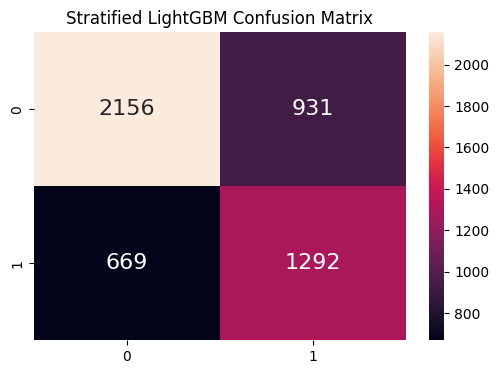

In [47]:
confusion_matrix_ = confusion_matrix(y_test, y_pred)
ax = plt.axes()
df_cm = pd.DataFrame(confusion_matrix_, range(2), range(2))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', ax = ax) # font size
ax.set_title('Stratified LightGBM Confusion Matrix')

print(classification_report(y_test, y_pred))

The model is able to predict whether a position within top 3 would be achieved with a fairly decent recall. 